# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_and_sharing"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.000400,0.005621,-0.071236,0.943213,0.528394,random.pheno988
1,LV2,0.004635,0.003859,1.201067,0.229769,0.114885,random.pheno988
2,LV3,-0.010357,0.008183,-1.265761,0.205644,0.897178,random.pheno988
3,LV4,-0.008805,0.009312,-0.945502,0.344438,0.827781,random.pheno988
4,LV5,0.002055,0.012122,0.169495,0.865413,0.432706,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.04902836879432624

# QQ-plot

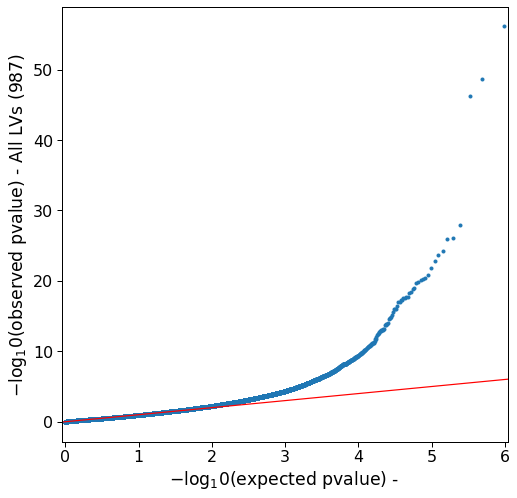

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.001,0.007,0.017
1,LV10,0.018,0.055,0.100
2,LV100,0.009,0.029,0.050
3,LV101,0.027,0.102,0.166
4,LV102,0.014,0.055,0.093


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014388,0.049028,0.089535
std,0.019224,0.037512,0.053520
min,0.000000,0.000000,0.000000
25%,0.003000,0.022000,0.055000
50%,0.011000,0.048000,0.094000
75%,0.018000,0.065000,0.119000
max,0.243000,0.348000,0.411000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(42, 4)

,lv,1,5,10
8,LV106,0.009,0.049,0.105
252,LV326,0.014,0.049,0.091
385,LV446,0.010,0.049,0.095
414,LV472,0.012,0.049,0.099
203,LV282,0.010,0.049,0.095
258,LV331,0.015,0.049,0.078
486,LV537,0.015,0.049,0.091
268,LV340,0.017,0.049,0.099
740,LV766,0.012,0.049,0.109
727,LV754,0.011,0.050,0.089


,lv,1,5,10
174,LV256,0.011,0.050,0.090
37,LV132,0.015,0.050,0.083
128,LV214,0.014,0.050,0.099
336,LV401,0.015,0.051,0.090
892,LV902,0.011,0.051,0.101
890,LV900,0.008,0.051,0.107
71,LV163,0.012,0.051,0.101
829,LV846,0.011,0.051,0.113
789,LV81,0.011,0.051,0.103
110,LV199,0.013,0.051,0.073


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(317, 4)

,lv,1,5,10
153,LV237,0.081,0.160,0.222
255,LV329,0.110,0.162,0.187
734,LV760,0.079,0.169,0.230
475,LV527,0.080,0.174,0.237
289,LV36,0.103,0.174,0.226
349,LV413,0.103,0.182,0.230
549,LV594,0.111,0.182,0.249
24,LV120,0.094,0.188,0.254
401,LV460,0.100,0.190,0.244
815,LV833,0.110,0.193,0.272


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010468,0.008595,1.217919,0.223299,0.111650,random.pheno988
1031,LV45,0.002765,0.008649,0.319680,0.749221,0.374611,random.pheno589
2018,LV45,0.001085,0.008575,0.126578,0.899278,0.449639,random.pheno385
3005,LV45,0.003858,0.008680,0.444523,0.656679,0.328340,random.pheno5
3992,LV45,-0.018297,0.008595,-2.128859,0.033304,0.983348,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.103

In [33]:
show_prop(results, 0.10)

0.153

In [34]:
show_prop(results, 0.15)

0.199

In [35]:
show_prop(results, 0.20)

0.236

### QQplot

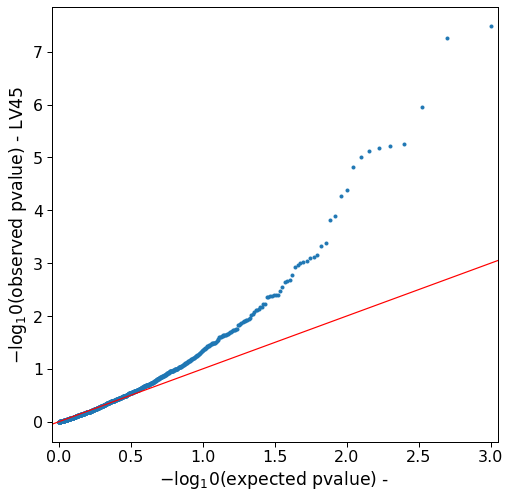

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.015661,0.010672,1.467436,0.142306,0.071153,random.pheno988
1220,LV234,0.003423,0.010740,0.318732,0.749940,0.374970,random.pheno589
2207,LV234,-0.004694,0.010648,-0.440820,0.659358,0.670321,random.pheno385
3194,LV234,0.004888,0.010778,0.453528,0.650184,0.325092,random.pheno5
4181,LV234,0.003740,0.010676,0.350333,0.726101,0.363050,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.016

In [43]:
show_prop(results, 0.05)

0.056

In [44]:
show_prop(results, 0.10)

0.103

In [45]:
show_prop(results, 0.15)

0.156

In [46]:
show_prop(results, 0.20)

0.2

### QQplot

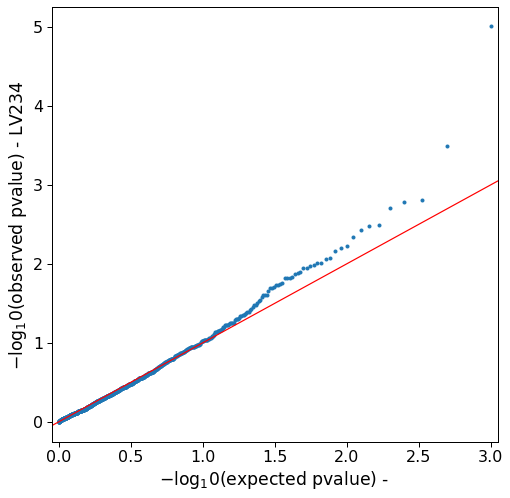

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002127,0.010906,0.195047,0.845363,0.422681,random.pheno988
1833,LV847,-0.003064,0.010974,-0.279171,0.780122,0.609939,random.pheno589
2820,LV847,-0.013167,0.010879,-1.210270,0.226220,0.886890,random.pheno385
3807,LV847,-0.003892,0.011013,-0.353436,0.723773,0.638113,random.pheno5
4794,LV847,0.007035,0.010909,0.644911,0.519008,0.259504,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.009

In [54]:
show_prop(results, 0.05)

0.055

In [55]:
show_prop(results, 0.10)

0.095

In [56]:
show_prop(results, 0.15)

0.138

In [57]:
show_prop(results, 0.20)

0.176

### QQplot

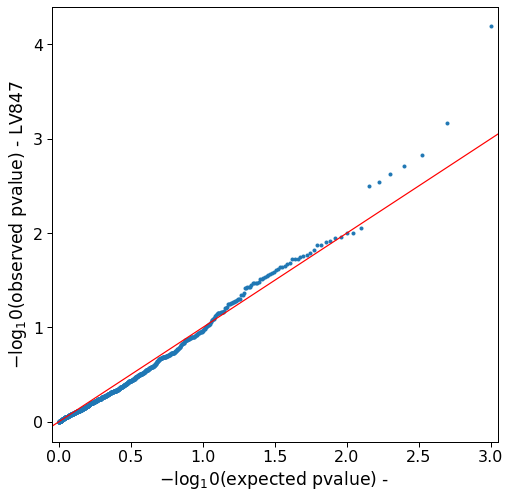

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022729,0.008884,-2.558432,0.010537,0.994731,random.pheno988
1096,LV110,-0.013146,0.008942,-1.470078,0.141590,0.929205,random.pheno589
2083,LV110,-0.008622,0.008867,-0.972363,0.330907,0.834547,random.pheno385
3070,LV110,-0.008586,0.008975,-0.956736,0.338737,0.830632,random.pheno5
4057,LV110,0.008352,0.008890,0.939472,0.347524,0.173762,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.016

In [65]:
show_prop(results, 0.05)

0.053

In [66]:
show_prop(results, 0.10)

0.095

In [67]:
show_prop(results, 0.15)

0.14

In [68]:
show_prop(results, 0.20)

0.188

### QQplot

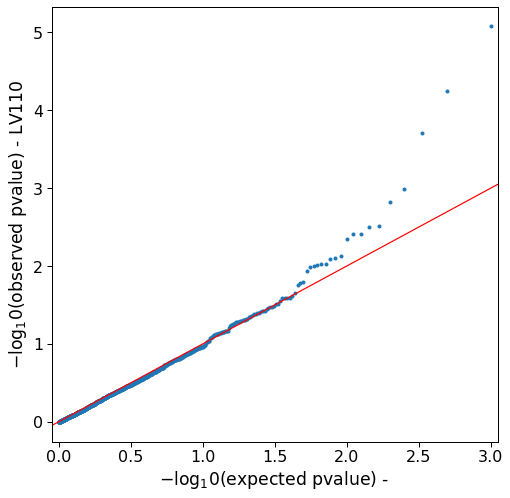

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.015774,0.010464,1.507544,0.131720,0.065860,random.pheno988
1755,LV769,-0.007971,0.010530,-0.757022,0.449065,0.775468,random.pheno589
2742,LV769,-0.009657,0.010440,-0.924981,0.355010,0.822495,random.pheno385
3729,LV769,-0.015454,0.010566,-1.462651,0.143612,0.928194,random.pheno5
4716,LV769,-0.022948,0.010464,-2.193019,0.028342,0.985829,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.052

In [76]:
show_prop(results, 0.05)

0.145

In [77]:
show_prop(results, 0.10)

0.207

In [78]:
show_prop(results, 0.15)

0.262

In [79]:
show_prop(results, 0.20)

0.306

### QQplot

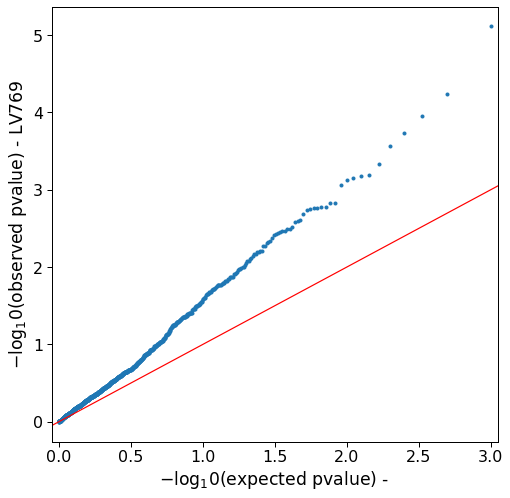

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.008069,0.012972,0.622046,0.533933,0.266967,random.pheno988
1786,LV800,-0.013530,0.013052,-1.036672,0.299928,0.850036,random.pheno589
2773,LV800,-0.002972,0.012941,-0.229657,0.818365,0.590817,random.pheno385
3760,LV800,-0.016274,0.013097,-1.242566,0.214073,0.892963,random.pheno5
4747,LV800,-0.014471,0.012974,-1.115428,0.264709,0.867646,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.009

In [87]:
show_prop(results, 0.05)

0.047

In [88]:
show_prop(results, 0.10)

0.095

In [89]:
show_prop(results, 0.15)

0.146

In [90]:
show_prop(results, 0.20)

0.197

### QQplot

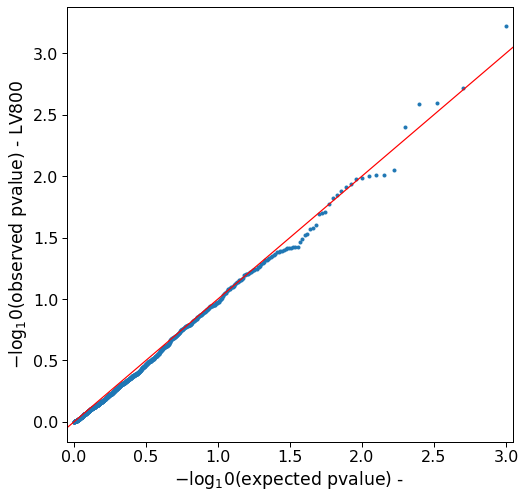

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
8,LV106,0.009,0.049,0.105
252,LV326,0.014,0.049,0.091
385,LV446,0.010,0.049,0.095
414,LV472,0.012,0.049,0.099
203,LV282,0.010,0.049,0.095
258,LV331,0.015,0.049,0.078
486,LV537,0.015,0.049,0.091
268,LV340,0.017,0.049,0.099
740,LV766,0.012,0.049,0.109
727,LV754,0.011,0.050,0.089


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.000945,0.007837,0.120574,0.904032,0.452016,random.pheno988
1398,LV412,-0.007759,0.007885,-0.983967,0.325169,0.837416,random.pheno589
2385,LV412,0.005697,0.007818,0.728680,0.466224,0.233112,random.pheno385
3372,LV412,-0.005373,0.007913,-0.678976,0.497178,0.751411,random.pheno5
4359,LV412,0.002880,0.007839,0.367361,0.713362,0.356681,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.0

In [100]:
show_prop(results, 0.05)

0.019

In [101]:
show_prop(results, 0.10)

0.055

In [102]:
show_prop(results, 0.15)

0.101

In [103]:
show_prop(results, 0.20)

0.141

### QQplot

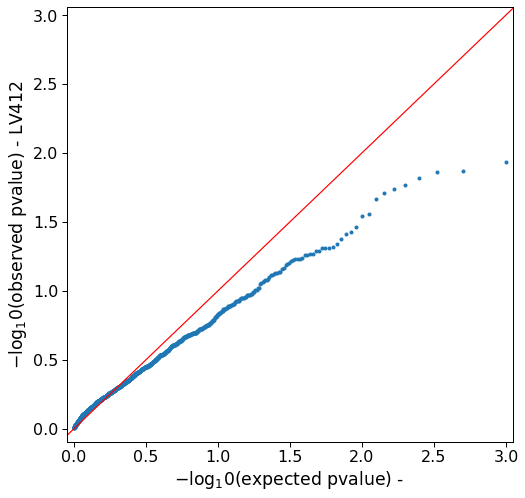

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.026387,0.011091,-2.379148,0.017382,0.991309,random.pheno988
1043,LV57,0.000653,0.011165,0.058513,0.953341,0.476671,random.pheno589
2030,LV57,0.022235,0.011066,2.009302,0.044547,0.022273,random.pheno385
3017,LV57,-0.004678,0.011204,-0.417535,0.676301,0.661850,random.pheno5
4004,LV57,0.011000,0.011097,0.991210,0.321620,0.160810,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.008

In [111]:
show_prop(results, 0.05)

0.055

In [112]:
show_prop(results, 0.10)

0.113

In [113]:
show_prop(results, 0.15)

0.161

In [114]:
show_prop(results, 0.20)

0.204

### QQplot

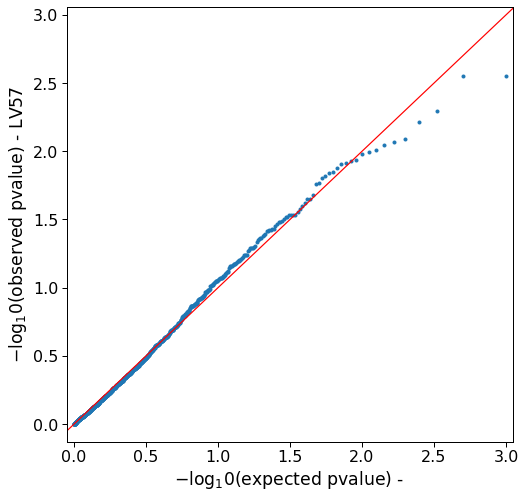

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007279,0.010897,-0.667954,0.504187,0.747906,random.pheno988
1633,LV647,0.007451,0.010964,0.679581,0.496794,0.248397,random.pheno589
2620,LV647,0.014262,0.010870,1.312095,0.189535,0.094767,random.pheno385
3607,LV647,-0.001645,0.011004,-0.149513,0.881153,0.559423,random.pheno5
4594,LV647,0.014448,0.010898,1.325720,0.184979,0.092490,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.021

In [122]:
show_prop(results, 0.05)

0.071

In [123]:
show_prop(results, 0.10)

0.115

In [124]:
show_prop(results, 0.15)

0.158

In [125]:
show_prop(results, 0.20)

0.205

### QQplot

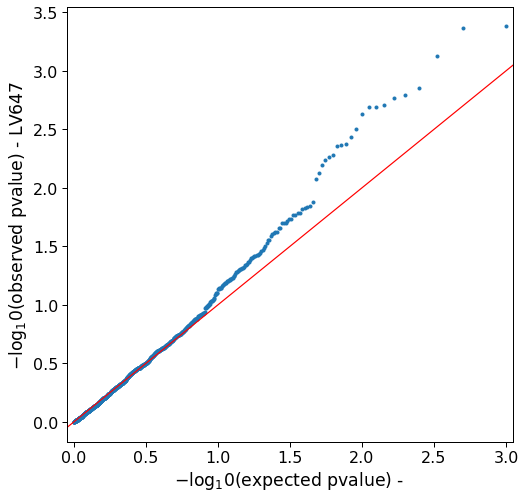

In [126]:
qqplot_unif(results)